# The Convex Hull Problem 
Pound a bunch of nails into a board, then stretch a rubber band around them and let the rubber band snap taut, like this:

<img src="images/convex-hull-canonical.gif">

The rubber band has traced out the _convex hull_ of the set of nails. It turns out this is an important problem in computer graphics, robot motion planning, geographical information systems, ethology, and other areas. More formally, we say that:

> *Given a finite set, **P**, of points in a plane, the convex hull of **P** is a polygon, **H**, such that*:
* *Every point in **P** lies either on or inside of **H**.*
* *Every vertex of **H** is a point in **P**.*
* _**H** is convex; a line segment joining any two vertexes of **H** either is an edge of **H** or lies inside **H**._

In this notebook we develop an algorithm to find the convex hull (and show examples of how to use `matplotlib` plotting). The first thing to do is decide how we will represent objects of interest:

* **Point**: We'll define a class point such that `Point(3,4)` is a point where `p.x` is 3 and `p.y` is 4.
* **Set of Points**: We'll use a python set: `{Point(0,0), Point(3,4),...}`
* **Polygon**: We'll represent a polygon as an ordered list of vertex points.

First, we can get out imports out of the way:

In [1]:
from __future__ import division, print_function

%matplotlib inline
import matplotlib.pyplot as plt
import collections
import random
import math

# Points and Sets of Points
We can define the class `Point` as a named tuple of `x` and `y` coordinates, and `Points(n)` as a function that creates a set of `n` random points. 

There are two complications to the function `Points(n)`:
1. A second optional argument is used to set the random seed. This way, the same call to `Points` will return the same result each time. That makes it easier to reproduce tests. If you want a different set of points, just pass in different values for the seed.
2. Since `matplotlib` plots on a 3x2 rectangle by default, the points will be uniformly sampled from a 3x2 box (with a small border of 0.05 on each edge to prevent the points from bumping up against the edge of the box). 

In [85]:
"Defining our class Point"
Point = collections.namedtuple('Point', 'x, y')

def Points(n, seed=42):
  "Generate n random points within a 3 x 2 box."
  random.seed((n, seed))
  b = 0.05 # border
  return {Point(random.uniform(b, 3-b), random.uniform(b, 2-b)) for _ in range(n)}

In [86]:
Points(3)

{Point(x=0.15172583449638682, y=1.6108693392839208),
 Point(x=0.968326330695687, y=1.3139550880088586),
 Point(x=1.3508070075242857, y=0.22290610532132638)}

# Visualizing Points and Line Segments
Now let's see how to visualize points; we'll define a function `plot_points`. We will want to see:
* The **points** themselves.
* Optionally, **line segments** between points. An optional `style` parameter allows you to specificy whether you want lines or not, and what color they should be. This parameter uses the standard style format defined by matplotlib; for example, `r.` means red colored dots with no lines, `bs-` means blue colored squares with lines between them, and `go:` means green colored circles with dotted lines between them. The lines go from point to point in order; if you want the lines to close back from the last point to the first (to form a complex polygon), specify `closed=True`. (For that to work, the collection of points must be a list; with `closed=False`, the collection can be any collection.)
* Optionally, **labels** on the points that let us distinguish one from another. You get labels (integeres from 0 to _n_) if you specify `labels=True`.

In [142]:
def plot_points(points, style='r.', labels=False, closed=False):
  """Plot a collection of points. Optionally change the line style, label points with #s, 
  and/or form a closed polygon by closing the line from the last point to the first"""
  if labels: 
    for (i, (x, y)) in enumerate(points):
      plt.text(x, y, '  ' + str(i))
  if closed:
    points = points + [points[0]]
  plt.plot([p.x for p in points], [p.y for p in points], style, linewidth=2.5)
  plt.axis('scaled'); plt.axis('off')

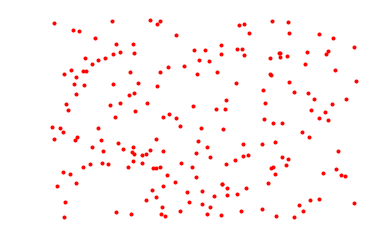

In [145]:
plot_points(Points(200))

# Convexity 
We want to make a _convex_ hull, so we better have some way of determining whether a polygon is `convex`. Let's examine one that is:

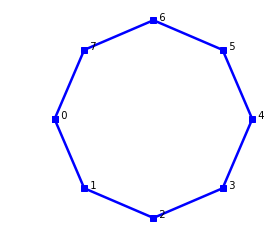

In [144]:
octagon = [Point(-10, 0), Point(-7, -7), Point(0, -10), Point(+7, -7), 
           Point(+10, 0), Point(+7, +7), Point(0, +10), Point(-7, 7)]
plot_points(octagon, 'bs-', labels=True, closed=True)

If you start at point 0 at the left and proceed in order counterclockwise around the octagon, following edges from point to point, you can see that at every vertex you are making a **left** turn. 

Now let's consider a non-convex polygon:

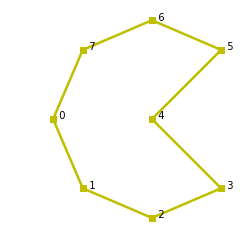

In [146]:
pacman = octagon[:4] + [Point(0, 0)] + octagon[5:]
plot_points(pacman, 'ys-', labels=True, closed=True)

The `pacman` polygon is non-convex; you can see that a line from point 3 to point 5 passes _outside_ the polygon. You can also see that as you move counter clockwise from 3 to 4 to 5 you turn **right** at 4. That leads to the idea: **a polygon is convex if there are no right turns** as we go around the polygon counterclockwise. 

# Turn Directions
Now how do we determine if a turn from point A to B to C is a left turn at B or a right turn (or straight)? Consider this diagram:

<img src="images/left-vs-right-turn.jpeg">

It is a left turn at B if angle $\beta$ is bigger than angle $\alpha$; in other words, if $\beta$'s opposite-over-adjacent ratio is bigger than $\alpha$'s:
> `(C.y - B.y) / (C.x - B.x) > (B.y - A.y) / (B.x - A.x)`

But if we did that computation, we'd need special cases for when each denominator is zero. So multiply each side by the denominators:
> `(B.x - A.x) * (C.y - B.y) > (B.y - A.y) * (C.x - B.x)`